In [1]:
import torch, os
import torch.nn.functional as F
import lightning as pl
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import rearrange

from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST

from modules.trainers.DDPM import DDPM

In [2]:
model = DDPM.load_from_checkpoint('./genmod/ljyckzmn/checkpoints/last.ckpt')
model.eval()

DDPM(
  (nn_model): ContextUnet(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): GELU(approximate='none')
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): GELU(approximate='none')
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualConvBlock(
          (conv1): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (2): GELU(approximate='none')
          )
          (conv2): Sequential(
            (0): Conv2d(128, 128, k

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


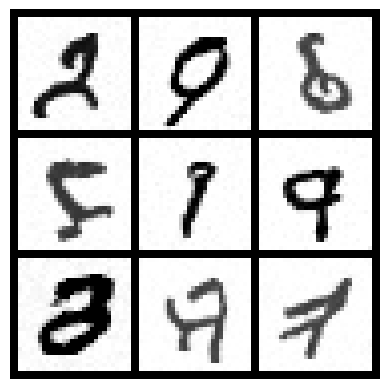

In [6]:
device = "cuda:0"

torch.cuda.empty_cache()

model = model.to(device)

gen_imgs = []
with torch.no_grad():
    x_i = torch.randn((9,1,28,28)).to(device)  # x_T ~ N(0, 1), sample initial noise
    x_0 = model.sample_loop(x_i)

gen_imgs.append(x_0.detach().cpu())


    
gen_imgs = rearrange(gen_imgs, '1 b c h w -> b c h w')
# create grid
grid = make_grid(gen_imgs*-1 + 1, nrow=3, padding=2)

# plot grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()